Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity Self-Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

### Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to pre-train a `ContrastiveModel()` on the cifar100 dataset.

You are going to learn the main features offered by the `ContrastiveModel()` and will:

1. Create a `SingleShotMemorySampler()` that will generate two augmented views for each example in a batch.

2. Create basic versions of **Backbone**, **Projector**, and **Predictor** networks. These will be used to construct the `ContrastiveModel()`

3. Build a `ContrastiveModel()` using one of the three supported algorithms.

4. Compare the classification performance of training from scratch vs. using the frozen pre-trainined weights.

### Things to try

You can try the following things to improve the model performance:
- Try different self-supervised learning algorithms.
- Use a larger backbone model.
- Use a larger embedding by increasing the size of the projection and predictor layers.
- Try using other augmention functions.

In [1]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
# install TF addons if needed
try:
    import tensorflow_addons as tfa  # main package
except ModuleNotFoundError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

In [6]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

2021-12-22 22:31:05.566451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-22 22:31:05.567440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

## Dataset Preperation

We are going to load the CIFAR100 dataset and partition the data into the following splits:
* **Train**: Data used for the pre-training and evaluation training phases.
* **Validation** Data used for validation metrics during the pre-training phase. 
* **Test** Data reserved for the evaluation tests.
* **Query and Index** Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

In [ ]:
data_path = Path("../../kaggle_ds/google_landmarks")

### Loading

In [ ]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
print(f"Class Names: {ds_info.features['label'].names}")

In [ ]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:200])  # 200 query examples per class
    index_idxs.extend(idxs[200:400])  # 200 index examples per class
    val_idxs.extend(idxs[400:500])  # 100 validation examples per class
    train_idxs.extend(idxs[500:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [3]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

NameError: name 'query_idxs' is not defined

In [4]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["test", x_test.shape, y_test.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

NameError: name 'x_train' is not defined

### Global Vars

In [13]:
ALGORITHM = "simsiam"  # @param ["barlow", "simsiam", "simclr"]

In [14]:
CIFAR_IMG_SIZE = 32

if ALGORITHM == "simsiam":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 800
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "barlow":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000  # we have 10k train steps and we warm up over 10% of that.
    DIM = 2048  # The layer size for the projector and predictor models.
elif ALGORITHM == "simclr":
    BATCH_SIZE = 512
    PRE_TRAIN_EPOCHS = 100
    PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
    VAL_STEPS_PER_EPOCH = 20
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  # Initial LR for the learning rate schedule.
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    DIM = 2048  # The layer size for the projector and predictor models.

## Single Shot DataSet

Self-supervised networks require two augmented "views" of each example. This can be created using a DataSet and an augmentation function. The DataSet treats each example in the batch as it's own class and then the augment function produces two separate views for each example. 

This means the resulting batch will yield tuples containing the two views, i.e., `Tuple[(BATCH_SIZE, 32, 32, 3), (BATCH_SIZE, 32, 32, 3)]`. 

TensorFlow Similarity provides several random augmentation functions, and here we are using the `SimCLRAugmenter()`. This augmenter returns values between [0, 1], but our ResNet backbone model expects the values to be between [0, 255] so we also scale the final output values in the augmentation function.

In [15]:
@tf.function
def simsiam_augmenter(img, blur=True, area_range=(0.2, 1.0)):
    """SimSiam augmenter.

    The SimSiam augmentations are based on the SimCLR augmentations, but have
    some important differences.
    * The crop area lower bound is 20% instead of 8%.
    * The color jitter and grayscale are applied separately instead of together.
    * The color jitter ranges are much smaller.
    * Blur is not applied for the cifar10 dataset.

    args:
        img: Single image tensor of shape (H, W, C)
        blur: If true, apply blur. Should be disabled for cifar10.
        area_range: The upper and lower bound of the random crop percentage.

    returns:
        A single image tensor of shape (H, W, C) with values between 0.0 and 1.0.
    """
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=area_range
    )
    img /= 255.0
    # random color jitter
    def _jitter_transform(x):
        return tfsim.augmenters.simclr.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "simclrv2",
        )

    img = tfsim.augmenters.simclr.random_apply(_jitter_transform, p=0.8, x=img)

    # # random grayscale
    def _grascayle_transform(x):
        return tfsim.augmenters.simclr.to_grayscale(x)

    img = tfsim.augmenters.simclr.random_apply(_grascayle_transform, p=0.2, x=img)

    # optional random gaussian blur
    if blur:
        img = tfsim.augmenters.simclr.random_blur(img, p=0.5)

    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 1.0)

    return img


@tf.function()
def process(img):
    # SimClrAugmenter returns scaled values between [0,1]
    view1 = simsiam_augmenter(img, blur=False)
    view2 = simsiam_augmenter(img, blur=False)
    # The ResNet model scales internally and expects the inputs to be between [0, 255]
    return (view1 * 255.0, view2 * 255.0)


train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.repeat()
val_ds = val_ds.shuffle(1024)
val_ds = val_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Visualize Batching

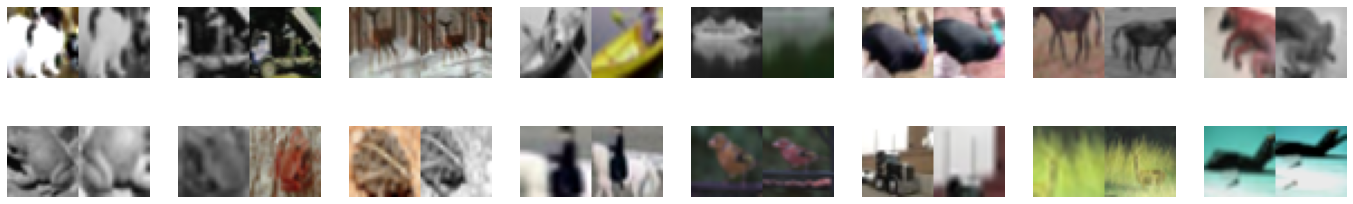

In [16]:
tfsim.visualization.visualize_views(
    views=next(train_ds.as_numpy_iterator()),
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=255.0,
)

## Models

There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Several papers claim that the batch normalization is critical to prevent the model from colapsing to a degenerate solution.

### Backbone Model

Describe why we don't use ImageNet weights

In [1]:
def get_backbone(
    img_size, activation="relu", preproc_mode="torch"
):
    input_shape = (img_size, img_size, 3)
    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        augmentation=None,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",  # Use GeneralizedMeanPooling2D
        # gem_p=3.0,  # Increase the contrast between activations in the feature map.
        preproc_mode="torch",
        similarity_model=False, # We don't need indexing on the backbone.
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE)
backbone.summary()

NameError: name 'CIFAR_IMG_SIZE' is not defined

### Projector Model

In [18]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs
    
    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(
            epsilon=1.001e-5, name=f"batch_normalization_{i}"
        )(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  # Page:5, Paragraph:2 of SimSiam paper
        scale=False,  # Page:5, Paragraph:2 of SimSiam paper
        name=f"batch_normalization_ouput",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
projector_input (InputLayer) [(None, 512)]             0         
_________________________________________________________________
projector_layer_0 (Dense)    (None, 2048)              1048576   
_________________________________________________________________
batch_normalization_0 (Batch (None, 2048)              8192      
_________________________________________________________________
relu_activation_0 (Activatio (None, 2048)              0         
_________________________________________________________________
projector_output (Dense)     (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_ouput (B (None, 2048)              4096      
_________________________________________________________________
proj_std (ActivationStdLoggi (None, 2048)              0 

### Predictor model

In [19]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5, name="batch_normalization_0"
    )(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
predictor_input (InputLayer) [(None, 2048)]            0         
_________________________________________________________________
predictor_layer_0 (Dense)    (None, 512)               1048576   
_________________________________________________________________
batch_normalization_0 (Batch (None, 512)               2048      
_________________________________________________________________
relu_activation_0 (Activatio (None, 512)               0         
_________________________________________________________________
predictor_output (Dense)     (None, 2048)              1050624   
_________________________________________________________________
pred_std (ActivationStdLoggi (None, 2048)              0         
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
___________________________________________

## Self-Supervised Algorithms

In [20]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor,  # NOTE: simiam requires predictor model.
        algorithm=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(
        learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9
    )
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    lr_decayed_fn = tfsim.schedules.WarmUpCosine(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
        warmup_steps=WARMUP_STEPS,
        warmup_learning_rate=WARMUP_LR,
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tf.keras.optimizers.Adam(INIT_LR)
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [21]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks

In [24]:
log_dir = data_path / "models_owen" / "logs" / f"{loss.name}_{time.time()}"
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="loss", patience=50, restore_best_weights=True
# )
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
tsc = tfsim.callbacks.EvalCallback(
    tf.cast(x_query, tf.float32),
    y_query,
    tf.cast(x_index, tf.float32),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
mcp_train = tf.keras.callbacks.ModelCheckpoint(
    filepath=data_path / "models_owen" / "checkpoints" / f"{loss.name}_{time.time()}",
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in ../../kaggle_ds/google_landmarks/models_owen/logs/simsiam_1640050051.278772/index


## Train

**Notes**
- SGDW seems to be required to prevent the loss from becoming unstable.
- Per layer kernel_regularization with weight decay doesn't work.
- The kernel initialization seems very critical. Smaller, uniform initalization schemes like Lecunn seem to work best.
- The projector is a more stable output for the KNN match metrics. The predictor ouput is typically worse and higher variance.
- The LR and weight decay schedule seem important. The loss becomes unstable if the updates are too large later in training.
- Too much capacity in the combined model and the training won't converge... same goes for too little capacity.
- Augmentation is critical, but too much augmentation and the model won't converge.

In [ ]:
history = contrastive_model.fit(
    train_ds,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[tsc, tbc, mcp_train],
)

Epoch 1/800
87/87 [==============================] - 52s 505ms/step - loss: 0.5494 - proj_std: 0.0176 - pred_std: 0.0134 - val_loss: 0.1491 - val_proj_std: 0.0091 - val_pred_std: 0.0050
binary_accuracy: 0.2340
Epoch 2/800
87/87 [==============================] - 42s 483ms/step - loss: 0.2796 - proj_std: 0.0159 - pred_std: 0.0115 - val_loss: 0.0713 - val_proj_std: 0.0070 - val_pred_std: 0.0037
binary_accuracy: 0.2165
Epoch 3/800
87/87 [==============================] - 42s 483ms/step - loss: 0.2997 - proj_std: 0.0178 - pred_std: 0.0149 - val_loss: 0.1270 - val_proj_std: 0.0096 - val_pred_std: 0.0066
binary_accuracy: 0.2295
Epoch 4/800
87/87 [==============================] - 42s 483ms/step - loss: 0.2003 - proj_std: 0.0153 - pred_std: 0.0123 - val_loss: 0.0799 - val_proj_std: 0.0089 - val_pred_std: 0.0070
binary_accuracy: 0.2405
Epoch 5/800
87/87 [==============================] - 42s 483ms/step - loss: 0.2062 - proj_std: 0.0165 - pred_std: 0.0139 - val_loss: 0.1075 - val_proj_std: 0.01

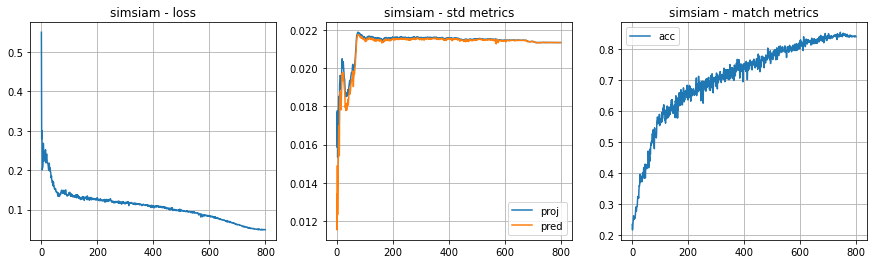

In [42]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - loss")

plt.subplot(1,3,2)
plt.plot(history.history["proj_std"], label="proj")
plt.plot(history.history["pred_std"], label="pred")
plt.grid()
plt.title(f"{loss.name} - std metrics")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - match metrics")
plt.legend()

plt.show()

In [22]:
contrastive_model.load_weights(data_path / 'models_owen' / 'checkpoints' / 'simsiam_80acc')

In [30]:
contrastive_model.save(data_path / 'models_owen' / f'simsiam_{time.time()}')

[Saving backbone model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/backbone


2021-12-22 01:33:13.295764: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/backbone/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/backbone/assets
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  'passed to the custom_objects argument.',


Index not saved as save_index=False
[Saving projector model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/projector


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/projector/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/projector/assets


[Saving predictor model]
|-path:../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/predictor


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/predictor/assets


INFO:tensorflow:Assets written to: ../../kaggle_ds/google_landmarks/models_owen/simsiam_1640136789.8832762/predictor/assets


ValueError: Model <tensorflow_similarity.models.contrastive_model.ContrastiveModel object at 0x7fc83c617dd0> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)`.

# Evaluation

In [23]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = int(len(x_train) // BATCH_SIZE)

In [24]:
@tf.function
def eval_augmenter(img):
    # random resize and crop. Increase the size before we crop.
    img = tfsim.augmenters.simclr.crop_and_resize(
        img, CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    img = tf.image.random_flip_left_right(img)
    img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [25]:
eval_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.keras.utils.to_categorical(y_train, 10))
)
eval_train_ds = eval_train_ds.repeat()
eval_train_ds = eval_train_ds.shuffle(1024)
eval_train_ds = eval_train_ds.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_ds = eval_train_ds.batch(BATCH_SIZE)
eval_train_ds = eval_train_ds.prefetch(tf.data.AUTOTUNE)

eval_val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val, tf.keras.utils.to_categorical(y_val, 10))
)
eval_val_ds = eval_val_ds.repeat()
eval_val_ds = eval_val_ds.shuffle(1024)
eval_val_ds = eval_val_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_val_ds = eval_val_ds.batch(BATCH_SIZE)
eval_val_ds = eval_val_ds.prefetch(tf.data.AUTOTUNE)

eval_test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, tf.keras.utils.to_categorical(y_test, 10))
)
eval_test_ds = eval_test_ds.map(lambda x, y: (x, y), tf.data.AUTOTUNE)
eval_test_ds = eval_test_ds.batch(BATCH_SIZE)
eval_test_ds = eval_test_ds.prefetch(tf.data.AUTOTUNE)

In [26]:
def get_eval_model(img_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(10, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(
        initial_learning_rate=lr, decay_steps=total_steps
    )
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

## No Pretrain

In [27]:
no_pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)
no_pt_history = no_pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 25s 243ms/step - loss: 2.0131 - acc: 0.2647 - val_loss: 1.7357 - val_acc: 0.3822
Epoch 2/10
87/87 [==============================] - 21s 239ms/step - loss: 1.7402 - acc: 0.3593 - val_loss: 1.5599 - val_acc: 0.4326
Epoch 3/10
87/87 [==============================] - 21s 239ms/step - loss: 1.6471 - acc: 0.3976 - val_loss: 1.4709 - val_acc: 0.4605
Epoch 4/10
87/87 [==============================] - 21s 239ms/step - loss: 1.5924 - acc: 0.4207 - val_loss: 1.4337 - val_acc: 0.4690
Epoch 5/10
87/87 [==============================] - 21s 238ms/step - loss: 1.5503 - acc: 0.4369 - val_loss: 1.3961 - val_acc: 0.4784
Epoch 6/10
87/87 [==============================] - 21s 239ms/step - loss: 1.5292 - acc: 0.4451 - val_loss: 1.3772 - val_acc: 0.4916
Epoch 7/10
87/87 [==============================] - 21s 239ms/step - loss: 1.5017 - acc: 0.4559 - val_loss: 1.3582 - val_acc: 0.4986
Epoch 8/10
87/87 [==============================] - 21s 238ms/step - 

## Pretrained

In [31]:
pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=30.0,
)
pt_eval_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eval_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
similarity_model (Similarity (None, 512)               11182784  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 11,187,914
Trainable params: 5,130
Non-trainable params: 11,182,784
_________________________________________________________________


In [32]:
pt_history = pt_eval_model.fit(
    eval_train_ds,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_ds,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
87/87 [==============================] - 7s 74ms/step - loss: 31.1377 - acc: 0.1163 - val_loss: 44.5136 - val_acc: 0.1013
Epoch 2/10
87/87 [==============================] - 6s 71ms/step - loss: 34.9489 - acc: 0.1345 - val_loss: 24.0295 - val_acc: 0.1002
Epoch 3/10
87/87 [==============================] - 6s 71ms/step - loss: 17.8638 - acc: 0.2199 - val_loss: 6.4628 - val_acc: 0.3262
Epoch 4/10
87/87 [==============================] - 6s 71ms/step - loss: 8.0052 - acc: 0.4032 - val_loss: 0.5676 - val_acc: 0.8104
Epoch 5/10
87/87 [==============================] - 6s 71ms/step - loss: 0.4164 - acc: 0.8684 - val_loss: 0.3193 - val_acc: 0.8976
Epoch 6/10
87/87 [==============================] - 6s 71ms/step - loss: 0.3911 - acc: 0.8759 - val_loss: 0.3373 - val_acc: 0.8955
Epoch 7/10
87/87 [==============================] - 6s 71ms/step - loss: 0.3776 - acc: 0.8798 - val_loss: 0.3138 - val_acc: 0.8994
Epoch 8/10
87/87 [==============================] - 6s 71ms/step - loss: 0.366

## Comparison

In [33]:
# SimSiam
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 2s 76ms/step - loss: 1.3804 - acc: 0.4982
no pretrain [1.3803918361663818, 0.498199999332428]
20/20 [==============================] - 1s 56ms/step - loss: 0.3760 - acc: 0.8791
pretrained [0.375978022813797, 0.8791000247001648]


In [40]:
# SimCLR
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

40/40 [==============================] - 1s 34ms/step - loss: 1.4910 - acc: 0.6161
no pretrain [1.491011142730713, 0.616100013256073]
40/40 [==============================] - 1s 30ms/step - loss: 2.0020 - acc: 0.4137
pretrained [2.002046823501587, 0.41370001435279846]


In [53]:
# Barlow Pre-train Cifar 10 Linear classifier on Cifar 100
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 32ms/step - loss: nan - acc: 0.1000
no pretrain [nan, 0.10000000149011612]
20/20 [==============================] - 1s 26ms/step - loss: 3.5400 - acc: 0.4260
pretrained [3.540032386779785, 0.4259999990463257]


In [63]:
# Barlow Pre-train Cifar 10 Linear classifier on Cifar 10
print("no pretrain", no_pt_eval_model.evaluate(eval_test_ds))
print("pretrained", pt_eval_model.evaluate(eval_test_ds))

20/20 [==============================] - 1s 32ms/step - loss: 2.5204 - acc: 0.3977
no pretrain [2.5204174518585205, 0.3977000117301941]
20/20 [==============================] - 1s 26ms/step - loss: 2.2891 - acc: 0.6451
pretrained [2.2890686988830566, 0.6450999975204468]
